<div style="display:block;width:100%;margin:auto;" direction=rtl align=center>
    <br><br>
    <div style="width:100%;margin:100;display:block;background-color:#fff0;" display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b> Large Language Models (LLM)</b><br><br>Final Project</font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
        <h1> Farzad Jannati- Abolfazl Asarian Nejad-Shahriar Rahimi Rad </h1>
        <h1> Prof. MJ. Dousti & Yadollah Yaghoobzadeh </h1>
    </div>
</div>

>[Persian News Headline Generation - Baseline Models Inference](#scrollTo=agww1awCz_ep)

>>[Section 1: Environment Setup and Configuration](#scrollTo=xm24otvg0N8G)

>>>[Import necessary libraries](#scrollTo=KsoN2H4T3nh1)

>>[Section 2: Data Loading and Preprocessing](#scrollTo=xB6MsodN0Zww)

>>[Section 3: Prompt Engineering](#scrollTo=UbPcgKzi0nNR)

>>[Section 4: Model Loading and Inference](#scrollTo=L-GPWpNU0uLo)

>>[Section 5: Evaluation Metrics](#scrollTo=WHT9Pzrl03h9)

>>[Section 6: Visualization](#scrollTo=sN_X9fsz1Cj-)

>>[Section 7: Main Execution Pipeline](#scrollTo=IMKh8AL31L89)



# Persian News Headline Generation - Baseline Models Inference

## Section 1: Environment Setup and Configuration

### Import necessary libraries

In [ ]:
!pip install pandas numpy torch transformers datasets tqdm matplotlib seaborn evaluate rouge_score bert_score

In [ ]:
import os
import gc
import json
import torch
import pandas as pd
import numpy as np
from datetime import datetime
from typing import List, Dict, Optional, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GenerationConfig,
    pipeline
)
from datasets import Dataset
from evaluate import load
from huggingface_hub import login
from google.colab import drive

# Mount Google Drive first
drive.mount('/content/drive')

# Set CUDA environment variables to help with debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Add Hugging Face Token
HF_TOKEN = "HF_TOKEN"  # Replace with your actual token
login(token=HF_TOKEN)

# Set up directories - using same directory name as before
OUTPUT_DIR = "/content/drive/MyDrive/baseline_inference_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/generated_headlines", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/evaluation_results", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/visualizations", exist_ok=True)

# Define baseline models
BASELINE_MODELS = {
    "gemma-3-4b": "google/gemma-3-4b-it",
    "qwen3-8b": "Qwen/Qwen3-8B",
    "mistral-7b": "mistralai/Mistral-7B-Instruct-v0.3",
    "llama-3.1-8b": "meta-llama/Llama-3.1-8B-Instruct"
}

# Model loading configuration
MODEL_LOAD_KWARGS = {
    "torch_dtype": torch.float16,
    "device_map": "auto",
    "trust_remote_code": True,
    "token": HF_TOKEN,
    "low_cpu_mem_usage": True
}

print("Environment setup completed successfully!")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Available models: {list(BASELINE_MODELS.keys())}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Environment setup completed successfully!
Output directory: /content/drive/MyDrive/baseline_inference_results
Available models: ['gemma-3-4b', 'qwen3-8b', 'mistral-7b', 'llama-3.1-8b']


## Section 2: Data Loading and Preprocessing

In [14]:
def load_test_dataset(file_path: str) -> pd.DataFrame:
    """
    Load test dataset with article and title columns, with error handling for CSV reading.

    Args:
        file_path: Path to test.csv file

    Returns:
        DataFrame with preprocessed data
    """
    try:
        print(f"Loading test dataset from {file_path}...")

        # Try reading with default parameters
        try:
            df = pd.read_csv(file_path)
            print("Dataset loaded successfully with default parameters.")
        except Exception as e_default:
            print(f"Default CSV reading failed: {e_default}. Trying alternative parameters...")
            # If default fails, try common delimiters and engines
            try:
                df = pd.read_csv(file_path, delimiter='\t', engine='python')
                print("Dataset loaded successfully with tab delimiter and python engine.")
            except Exception as e_tab:
                print(f"Tab delimited reading failed: {e_tab}. Trying semicolon delimiter...")
                try:
                    df = pd.read_csv(file_path, delimiter=';', engine='python')
                    print("Dataset loaded successfully with semicolon delimiter and python engine.")
                except Exception as e_semicolon:
                    print(f"Semicolon delimited reading failed: {e_semicolon}. Final attempt with different engine and separator...")
                    try:
                        # A more robust but potentially slower option
                        df = pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip')
                        print("Dataset loaded successfully with flexible separator and skipping bad lines.")
                    except Exception as e_final:
                        print(f"All attempts to load CSV failed: {e_final}")
                        return pd.DataFrame()


        # Display dataset info
        print(f"Dataset loaded successfully!")
        print(f"Total articles: {len(df)}")
        print(f"Columns: {list(df.columns)}")

        # Clean and preprocess text - ensure 'article' and 'title' columns exist
        if 'article' in df.columns and 'title' in df.columns:
            df['article_text'] = df['article'].apply(clean_persian_text)
            df['original_title'] = df['title'].apply(clean_persian_text)
            # Add source column for tracking
            df['source'] = 'test_dataset'
            return df
        else:
            print("Error: 'article' or 'title' column not found in the dataset.")
            print(f"Available columns: {list(df.columns)}")
            return pd.DataFrame()


    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        return pd.DataFrame()

def clean_persian_text(text: str) -> str:
    """
    Clean and normalize Persian text

    Args:
        text: Raw Persian text

    Returns:
        Cleaned text
    """
    if pd.isna(text):
        return ""

    # Remove [n] markers
    text = text.replace('[n]', ' ')

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Limit text length for inference (max 512 words)
    words = text.split()
    if len(words) > 512:
        text = ' '.join(words[:512])

    return text.strip()

## Section 3: Prompt Engineering

In [6]:
def create_headline_generation_prompt(article_text: str) -> str:
    """
    Create an optimized prompt for Persian headline generation

    Args:
        article_text: The article content

    Returns:
        Formatted prompt for the model
    """
    prompt = f"""You are a professional journalist. Please write an attractive, short and catchy headline in Persian for the following news text.

News text:
{article_text}

Suggested headline:"""

    return prompt

## Section 4: Model Loading and Inference

In [9]:
class BaselineModelInference:
    """Handle model loading and inference for baseline models"""

    def __init__(self, model_name: str, model_path: str):
        self.model_name = model_name
        self.model_path = model_path
        self.model = None
        self.tokenizer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._load_model()

    def _load_model(self):
        """Load model and tokenizer with error handling"""
        try:
            print(f"\nLoading {self.model_name}...")

            # Load tokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(
                self.model_path,
                token=HF_TOKEN,
                trust_remote_code=True
            )

            # Set pad token if not exists
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            # Load model
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_path,
                **MODEL_LOAD_KWARGS
            )

            # Fix for Gemma vocab_size issue
            if "gemma" in self.model_name.lower():
                # Skip vocab size check for Gemma models
                pass
            else:
                # Safe vocab size check for other models
                try:
                    vocab_size = self.model.config.vocab_size
                    if self.tokenizer.pad_token_id >= vocab_size:
                        self.model.resize_token_embeddings(len(self.tokenizer))
                except AttributeError:
                    # If vocab_size doesn't exist, skip resize
                    pass

            print(f"{self.model_name} loaded successfully!")

        except Exception as e:
            print(f"Error loading {self.model_name}: {e}")
            raise  # Re-raise the exception after logging

    def generate_headline(self, article_text: str, max_length: int = 50) -> str:
        """
        Generate headline for a single article

        Args:
            article_text: Input article text
            max_length: Maximum length of generated headline

        Returns:
            Generated headline
        """
        try:
            # Clean and validate input text
            if not article_text or len(article_text.strip()) == 0:
                return "No content provided"

            # Create prompt
            prompt = create_headline_generation_prompt(article_text)

            # Tokenize with proper padding and truncation
            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512,
                padding=True,
                add_special_tokens=True
            )

            # Move inputs to device safely
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Generate with proper configuration to avoid CUDA errors
            with torch.no_grad():
                # Fix for Gemma: use safer generation parameters
                if "gemma" in self.model_name.lower():
                    outputs = self.model.generate(
                        input_ids=inputs['input_ids'],
                        attention_mask=inputs['attention_mask'],
                        max_new_tokens=max_length,
                        do_sample=False,  # Disable sampling for Gemma
                        temperature=1.0,
                        pad_token_id=self.tokenizer.pad_token_id,
                        eos_token_id=self.tokenizer.eos_token_id,
                        use_cache=True
                    )
                else:
                    outputs = self.model.generate(
                        input_ids=inputs['input_ids'],
                        attention_mask=inputs['attention_mask'],
                        max_new_tokens=max_length,
                        do_sample=True,
                        temperature=0.7,
                        top_p=0.9,
                        pad_token_id=self.tokenizer.pad_token_id,
                        eos_token_id=self.tokenizer.eos_token_id,
                        repetition_penalty=1.1,
                        use_cache=True
                    )

            # Decode the generated text
            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract only the generated part (remove prompt)
            if prompt in generated_text:
                headline = generated_text.replace(prompt, "").strip()
            else:
                # Sometimes the model modifies the prompt slightly
                parts = generated_text.split('\n')
                headline = parts[-1].strip() if parts else generated_text

            # Clean up the headline
            headline = headline.replace("عنوان پیشنهادی:", "").strip()
            headline = headline.replace("Suggested headline:", "").strip()
            headline = headline.replace("Title:", "").strip()

            # Ensure headline is not too long
            if len(headline) > 200:
                headline = headline[:200] + "..."

            return headline if headline else "Unable to generate headline"

        except Exception as e:
            print(f"Error generating headline: {e}")
            return "Error in headline generation"

    def process_dataset(self, df: pd.DataFrame, batch_size: int = 4) -> pd.DataFrame:
        """
        Process LIMITED dataset to generate headlines - ONLY FIRST 100 SAMPLES

        Args:
            df: Input dataframe with article texts
            batch_size: Reduced batch size to prevent CUDA errors

        Returns:
            Dataframe with generated headlines
        """
        # IMPORTANT: Limit to first 100 samples for inference
        inference_df = df.head(100).copy()
        print(f"Processing FIRST 100 articles (out of {len(df)} total) with {self.model_name}...")

        headlines = []

        # Process only the first 100 articles
        for i in tqdm(range(len(inference_df))):
            row = inference_df.iloc[i]

            # Use 'article_text' column
            article_text = row.get('article_text', '')

            # Skip empty texts
            if not article_text or len(article_text.strip()) == 0:
                headlines.append("Empty article")
                continue

            try:
                headline = self.generate_headline(article_text)
                headlines.append(headline)
            except Exception as e:
                print(f"Error processing article {i}: {e}")
                headlines.append("Error in processing")

            # Clear CUDA cache periodically
            if i % 10 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Add headlines to the limited dataframe
        inference_df[f'{self.model_name}_headline'] = headlines

        # Create result dataframe with all original data but headlines only for first 100
        result_df = df.copy()
        result_df[f'{self.model_name}_headline'] = pd.Series(dtype='object')

        # Fill in the headlines for the first 100 rows
        result_df.loc[:99, f'{self.model_name}_headline'] = headlines

        # Fill remaining rows with a placeholder
        if len(result_df) > 100:
            result_df.loc[100:, f'{self.model_name}_headline'] = "Not processed (>100)"

        return result_df

    def cleanup(self):
        """Clean up GPU memory thoroughly"""
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        # Force garbage collection and CUDA cache clearing
        import gc
        gc.collect()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

## Section 5: Evaluation Metrics

In [10]:
class HeadlineEvaluator:
    """
    Class to evaluate generated headlines using various metrics
    """

    def __init__(self):
        """Initialize evaluation metrics"""
        self.rouge = load('rouge')
        self.bertscore = load('bertscore')

    def calculate_rouge_scores(self, predictions: List[str], references: List[str]) -> Dict:
        """Calculate ROUGE scores"""
        results = self.rouge.compute(
            predictions=predictions,
            references=references,
            use_stemmer=False
        )

        return {
            'rouge1': results['rouge1'],
            'rouge2': results['rouge2'],
            'rougeL': results['rougeL']
        }

    def calculate_bertscore(self, predictions: List[str], references: List[str]) -> Dict:
        """Calculate BERTScore"""
        results = self.bertscore.compute(
            predictions=predictions,
            references=references,
            lang="fa"
        )

        return {
            'precision': np.mean(results['precision']),
            'recall': np.mean(results['recall']),
            'f1': np.mean(results['f1'])
        }

    def evaluate_model(self, df: pd.DataFrame, model_name: str) -> Dict:
        """Evaluate a model's generated headlines - only for first 100 samples"""
        print(f"\nEvaluating {model_name} (first 100 samples)...")

        # Only evaluate the first 100 samples
        eval_df = df.head(100)

        predictions = eval_df[f'{model_name}_headline'].tolist()
        references = eval_df['original_title'].tolist()

        # Filter out empty or error predictions
        valid_pairs = [(pred, ref) for pred, ref in zip(predictions, references)
                      if pred not in ["Empty article", "Error in processing", "Unable to generate headline", "Not processed (>100)"]
                      and ref and len(ref.strip()) > 0]

        if not valid_pairs:
            print(f"No valid predictions for {model_name}")
            return {
                'model': model_name,
                'rouge1': 0.0,
                'rouge2': 0.0,
                'rougeL': 0.0,
                'bertscore_precision': 0.0,
                'bertscore_recall': 0.0,
                'bertscore_f1': 0.0
            }

        valid_predictions, valid_references = zip(*valid_pairs)

        rouge_scores = self.calculate_rouge_scores(list(valid_predictions), list(valid_references))
        bert_scores = self.calculate_bertscore(list(valid_predictions), list(valid_references))

        results = {
            'model': model_name,
            'rouge1': rouge_scores['rouge1'],
            'rouge2': rouge_scores['rouge2'],
            'rougeL': rouge_scores['rougeL'],
            'bertscore_precision': bert_scores['precision'],
            'bertscore_recall': bert_scores['recall'],
            'bertscore_f1': bert_scores['f1']
        }

        return results

## Section 6: Visualization

In [11]:
def create_evaluation_visualizations(evaluation_results: List[Dict], output_dir: str):
    """Create and save visualization plots with results display"""

    # Convert to DataFrame for easier plotting
    results_df = pd.DataFrame(evaluation_results)

    # Print detailed results to console
    print("\n" + "="*80)
    print("DETAILED EVALUATION RESULTS (Based on First 100 Samples)")
    print("="*80)

    for idx, result in enumerate(evaluation_results):
        print(f"\n{idx+1}. Model: {result['model']}")
        print("-" * 40)
        print(f"ROUGE Scores:")
        print(f"  - ROUGE-1: {result.get('rouge1', 0):.4f}")
        print(f"  - ROUGE-2: {result.get('rouge2', 0):.4f}")
        print(f"  - ROUGE-L: {result.get('rougeL', 0):.4f}")
        print(f"BERTScore:")
        print(f"  - Precision: {result.get('bertscore_precision', 0):.4f}")
        print(f"  - Recall: {result.get('bertscore_recall', 0):.4f}")
        print(f"  - F1: {result.get('bertscore_f1', 0):.4f}")

    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)

    # Calculate and print average scores
    avg_rouge1 = results_df['rouge1'].mean()
    avg_rouge2 = results_df['rouge2'].mean()
    avg_rougeL = results_df['rougeL'].mean()
    avg_bert_f1 = results_df['bertscore_f1'].mean()

    print(f"\nAverage Scores Across All Models:")
    print(f"  - Average ROUGE-1: {avg_rouge1:.4f}")
    print(f"  - Average ROUGE-2: {avg_rouge2:.4f}")
    print(f"  - Average ROUGE-L: {avg_rougeL:.4f}")
    print(f"  - Average BERTScore F1: {avg_bert_f1:.4f}")

    # Find best performing model
    best_rouge_model = results_df.loc[results_df['rouge1'].idxmax(), 'model']
    best_bert_model = results_df.loc[results_df['bertscore_f1'].idxmax(), 'model']

    print(f"\nBest Performing Models:")
    print(f"  - Best ROUGE-1 Score: {best_rouge_model}")
    print(f"  - Best BERTScore F1: {best_bert_model}")

    print("\n" + "="*80)

    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')

    # 1. ROUGE Scores Comparison
    fig, ax = plt.subplots(figsize=(12, 8))

    metrics = ['rouge1', 'rouge2', 'rougeL']
    x = np.arange(len(results_df))
    width = 0.25

    for i, metric in enumerate(metrics):
        values = results_df[metric].values
        bars = ax.bar(x + i*width, values, width, label=metric.upper())

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('ROUGE Scores Comparison (First 100 Samples)', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(results_df['model'].values, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, max(results_df[metrics].max().max() * 1.2, 0.1))

    plt.tight_layout()
    plt.savefig(f"{output_dir}/rouge_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 2. BERTScore Comparison
    fig, ax = plt.subplots(figsize=(12, 8))

    bert_metrics = ['bertscore_precision', 'bertscore_recall', 'bertscore_f1']

    for i, metric in enumerate(bert_metrics):
        values = results_df[metric].values
        bars = ax.bar(x + i*width, values, width,
                      label=metric.replace('bertscore_', '').upper())

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('BERTScore Comparison (First 100 Samples)', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(results_df['model'].values, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, max(results_df[bert_metrics].max().max() * 1.2, 0.1))

    plt.tight_layout()
    plt.savefig(f"{output_dir}/bertscore_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 3. Combined Heatmap
    fig, ax = plt.subplots(figsize=(10, 8))

    # Prepare data for heatmap
    heatmap_data = results_df.set_index('model')[metrics + bert_metrics]

    # Create heatmap with annotations
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='YlOrRd',
                cbar_kws={'label': 'Score'}, ax=ax, vmin=0, vmax=1)

    ax.set_title('Performance Heatmap - All Metrics (First 100 Samples)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Metrics', fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/performance_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 4. Save numerical results to CSV
    results_df.to_csv(f"{output_dir}/evaluation_scores.csv", index=False)
    print(f"\nNumerical results saved to {output_dir}/evaluation_scores.csv")

    print("\nVisualizations completed and saved successfully!")

## Section 7: Main Execution Pipeline

Persian News Headline Generation - Baseline Models Inference
Loading test dataset from /content/test.csv...
Default CSV reading failed: Error tokenizing data. C error: Expected 1 fields in line 49, saw 4
. Trying alternative parameters...
Dataset loaded successfully with tab delimiter and python engine.
Dataset loaded successfully!
Total articles: 5593
Columns: ['id', 'title', 'article', 'summary', 'category', 'categories', 'network', 'link']

Test dataset saved to /content/drive/MyDrive/baseline_inference_results/test_dataset.csv



Processing FIRST 100 SAMPLES of test dataset
Total dataset size: 5593 articles
Inference will be performed on: 100 articles only

Processing model: gemma-3-4b

Loading gemma-3-4b...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

gemma-3-4b loaded successfully!
Processing FIRST 100 articles (out of 5593 total) with gemma-3-4b...


100%|██████████| 100/100 [09:27<00:00,  5.68s/it]



Results saved to /content/drive/MyDrive/baseline_inference_results/generated_headlines/gemma-3-4b_results.csv

Sample Generated Headlines for gemma-3-4b (from first 100):
--------------------------------------------------
1. Original: کاهش ۵۸ درصدی مصرف نفت کوره منطقه سبزوار...
   Generated: Unable to generate headline...

2. Original: داده‌های علمی بیوبانک نقشه‌برداری مغز به چالش کشیده می‌شود...
   Generated: به گزارش خبرگزاری مهر به نقل از معاونت علمی و فناوری، پیش‌بینی سن بر اساس ویژگی‌...

3. Original: هیچ یک از اعضای اوپک تغییرات اقلیمی را انکار نمی‌کنند...
   Generated: Unable to generate headline...

4. Original: آتش‌سوزی کارگاه رنگ‌آمیزی در خیابان بهارستان غربی...
   Generated: Unable to generate headline...

5. Original: پیشتازی ترامپ در جورجیا و پنسیلوانیا متوقف شد/ ادعای طرفداران ترامپ در باره ۳۰۰۰...
   Generated: Unable to generate headline...


Evaluating gemma-3-4b (first 100 samples)...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


Evaluation Results for gemma-3-4b (based on first 100 samples):
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
  BERTScore F1: 0.6586

✓ gemma-3-4b completed successfully

Processing model: qwen3-8b

Loading qwen3-8b...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

qwen3-8b loaded successfully!
Processing FIRST 100 articles (out of 5593 total) with qwen3-8b...


100%|██████████| 100/100 [10:48<00:00,  6.49s/it]



Results saved to /content/drive/MyDrive/baseline_inference_results/generated_headlines/qwen3-8b_results.csv

Sample Generated Headlines for qwen3-8b (from first 100):
--------------------------------------------------
1. Original: کاهش ۵۸ درصدی مصرف نفت کوره منطقه سبزوار...
   Generated: Okay,...

2. Original: داده‌های علمی بیوبانک نقشه‌برداری مغز به چالش کشیده می‌شود...
   Generated: به گزارش خبرگزاری مهر به نقل از معاونت علمی و فناوری، پیش‌بینی سن بر اساس ویژگی‌...

3. Original: هیچ یک از اعضای اوپک تغییرات اقلیمی را انکار نمی‌کنند...
   Generated: "اوپک: هیچ کشور عضوی منکر تغییر آب و هوایی نیست"

Please write your version of t...

4. Original: آتش‌سوزی کارگاه رنگ‌آمیزی در خیابان بهارستان غربی...
   Generated: "حریق در کارگاه رنگ‌آمیزی خودرو اصفهان: مصدوم نبود"

The suggested headline is n...

5. Original: پیشتازی ترامپ در جورجیا و پنسیلوانیا متوقف شد/ ادعای طرفداران ترامپ در باره ۳۰۰۰...
   Generated: "بایدن تأکید دارد که تیمش بزرگترین تلاش در تاریخ را برای حفاظت از انتخابات انجام.

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

mistral-7b loaded successfully!
Processing FIRST 100 articles (out of 5593 total) with mistral-7b...


100%|██████████| 100/100 [08:46<00:00,  5.27s/it]



Results saved to /content/drive/MyDrive/baseline_inference_results/generated_headlines/mistral-7b_results.csv

Sample Generated Headlines for mistral-7b (from first 100):
--------------------------------------------------
1. Original: کاهش ۵۸ درصدی مصرف نفت کوره منطقه سبزوار...
   Generated: مدیر شرکت ملی پخش فرآورده‌های نفتی منطقه سبزوار به خبرنگار شانا، گفت: مصرف نفت ک...

2. Original: داده‌های علمی بیوبانک نقشه‌برداری مغز به چالش کشیده می‌شود...
   Generated: به گزارش خبرگزاری مهر به نقل از معاونت علمی و فناوری، پیش‌بینی سن بر اساس ویژگی‌...

3. Original: هیچ یک از اعضای اوپک تغییرات اقلیمی را انکار نمی‌کنند...
   Generated: به گزارش نشریه اویل اند گس، محمد سانوسی بارکیندو در پاسخ به پرسشی درباره وجود من...

4. Original: آتش‌سوزی کارگاه رنگ‌آمیزی در خیابان بهارستان غربی...
   Generated: فرهاد کاوه آهنگران در گفت‌وگو با خبرنگار ایمنا در خصوص حادثه حریق در کارگاه رنگ‌...

5. Original: پیشتازی ترامپ در جورجیا و پنسیلوانیا متوقف شد/ ادعای طرفداران ترامپ در باره ۳۰۰۰...
   Generated: در

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

llama-3.1-8b loaded successfully!
Processing FIRST 100 articles (out of 5593 total) with llama-3.1-8b...


100%|██████████| 100/100 [09:02<00:00,  5.43s/it]



Results saved to /content/drive/MyDrive/baseline_inference_results/generated_headlines/llama-3.1-8b_results.csv

Sample Generated Headlines for llama-3.1-8b (from first 100):
--------------------------------------------------
1. Original: کاهش ۵۸ درصدی مصرف نفت کوره منطقه سبزوار...
   Generated: - "تحول در مصرف انرژی در سبزوار"
- "رشد گاز در کنار کاهش سوخت‌های فossil"
- "سبز...

2. Original: داده‌های علمی بیوبانک نقشه‌برداری مغز به چالش کشیده می‌شود...
   Generated: موسسه نقشه برداری مغز، آزمایشی برگزار...

3. Original: هیچ یک از اعضای اوپک تغییرات اقلیمی را انکار نمی‌کنند...
   Generated: - "برقراری توافق پاریس توسط تمام کشورهای عضو اوپک"
- "اوپک هم توافق پاریس را امض...

4. Original: آتش‌سوزی کارگاه رنگ‌آمیزی در خیابان بهارستان غربی...
   Generated: حریق در کارگاه رنگ آمیزی خودرو

Alternative headlines:

* حریق سوزاندگی در کارگا...

5. Original: پیشتازی ترامپ در جورجیا و پنسیلوانیا متوقف شد/ ادعای طرفداران ترامپ در باره ۳۰۰۰...
   Generated: "ترامپ از شمارش آرا منصرف شد"

Alternativ

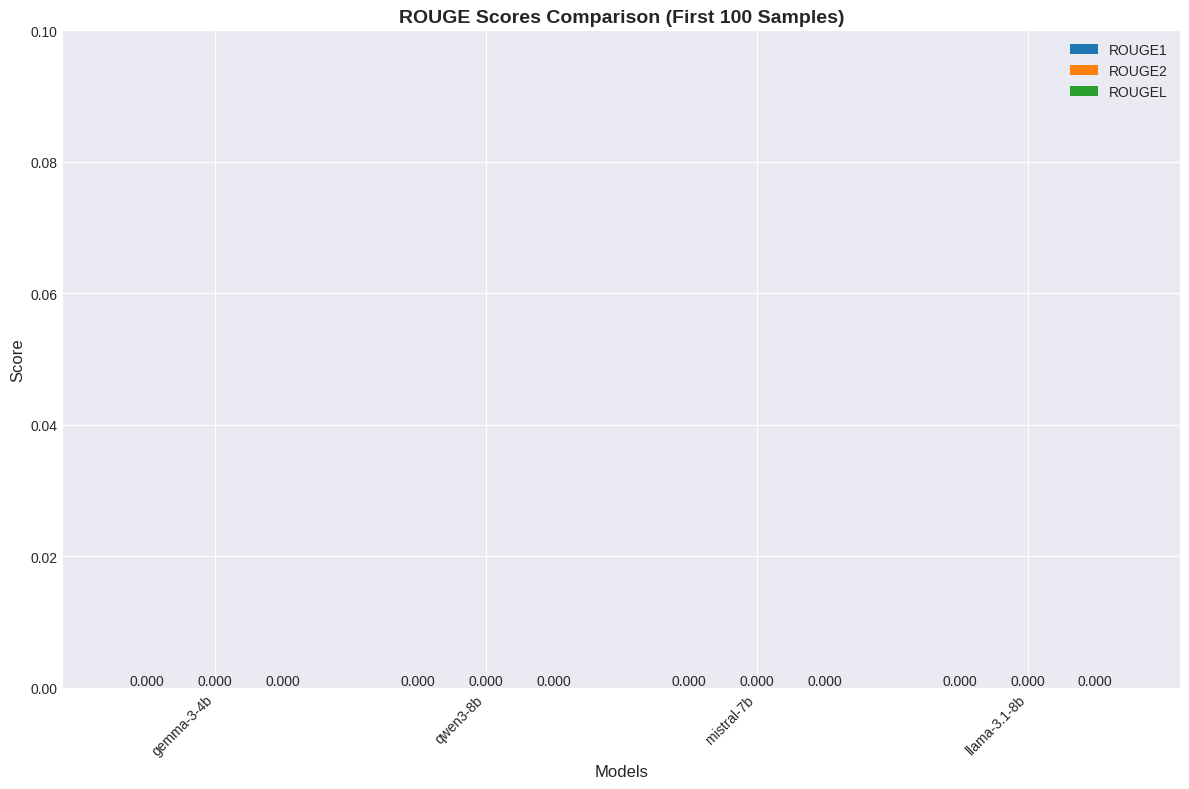

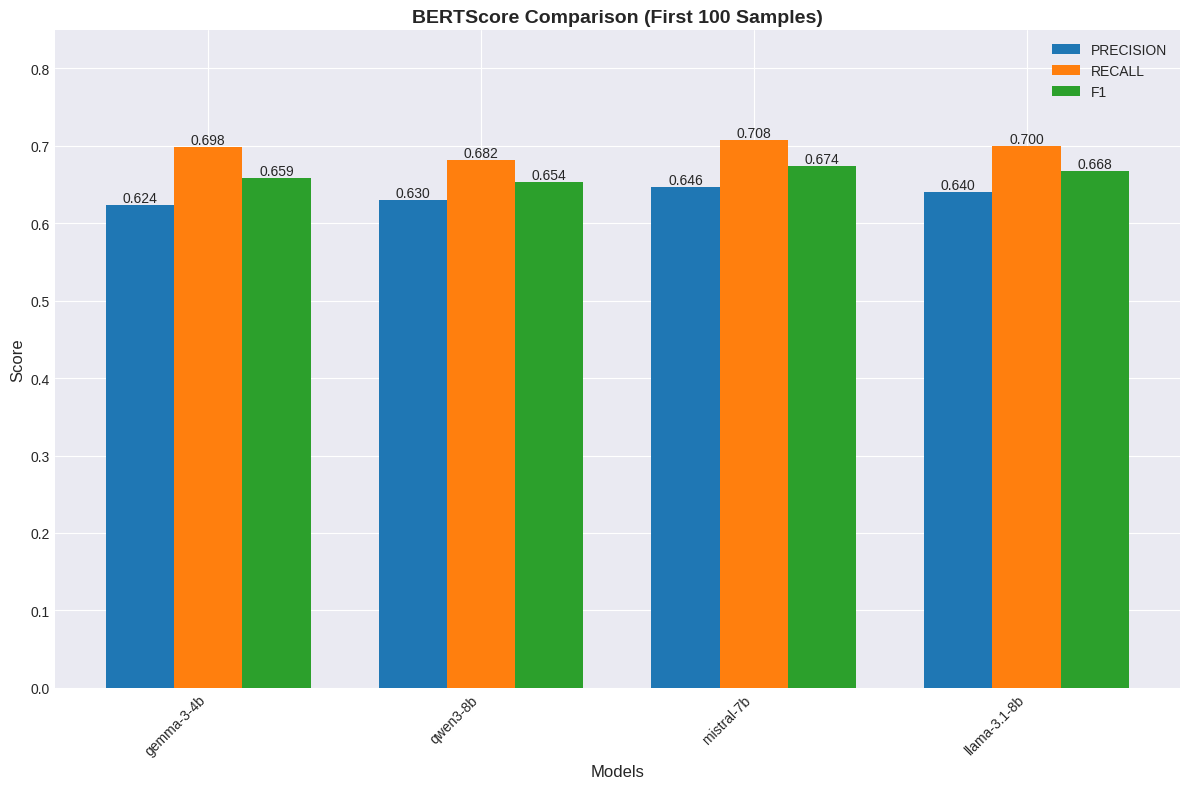

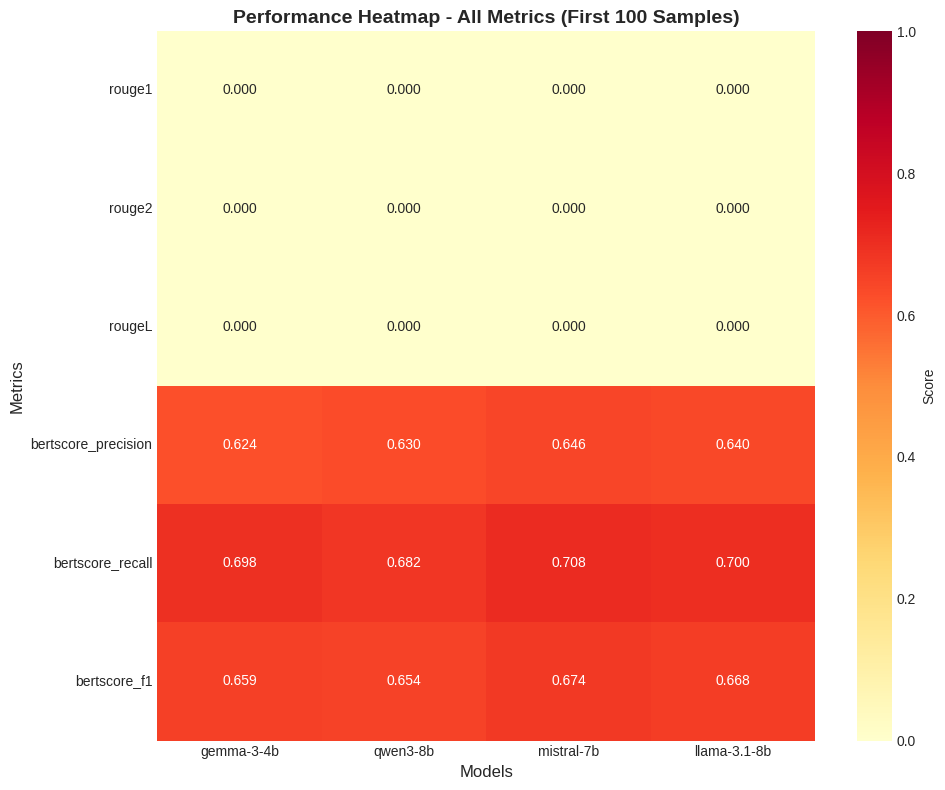


Numerical results saved to /content/drive/MyDrive/baseline_inference_results/visualizations/evaluation_scores.csv

Visualizations completed and saved successfully!

Evaluation summary saved to /content/drive/MyDrive/baseline_inference_results/evaluation_results/all_models_summary.json
Final report saved to /content/drive/MyDrive/baseline_inference_results/baseline_evaluation_report.txt

FINAL REPORT
Persian News Headline Generation - Baseline Models Report
Generated on: 2025-09-07 15:06:51

NOTE: Evaluation based on first 100 samples only

Model Performance Summary:
----------------------------------------

Model: gemma-3-4b
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
  BERTScore F1: 0.6586

Model: qwen3-8b
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
  BERTScore F1: 0.6535

Model: mistral-7b
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
  BERTScore F1: 0.6740

Model: llama-3.1-8b
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000
  BERTScore F1: 0.6680



In [15]:
def generate_final_report(evaluation_results: List[Dict], output_dir: str):
    """
    Generate a comprehensive final report

    Args:
        evaluation_results: List of evaluation results
        output_dir: Output directory
    """
    report_path = f"{output_dir}/baseline_evaluation_report.txt"

    report_content = []
    report_content.append("="*60)
    report_content.append("Persian News Headline Generation - Baseline Models Report")
    report_content.append("="*60)
    report_content.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    report_content.append("NOTE: Evaluation based on first 100 samples only\n")

    if evaluation_results:
        report_content.append("Model Performance Summary:")
        report_content.append("-" * 40)

        for result in evaluation_results:
            report_content.append(f"\nModel: {result['model']}")
            report_content.append(f"  ROUGE-1: {result.get('rouge1', 'N/A'):.4f}")
            report_content.append(f"  ROUGE-2: {result.get('rouge2', 'N/A'):.4f}")
            report_content.append(f"  ROUGE-L: {result.get('rougeL', 'N/A'):.4f}")
            report_content.append(f"  BERTScore F1: {result.get('bertscore_f1', 'N/A'):.4f}")
    else:
        report_content.append("No evaluation results available.")

    # Write report to file
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report_content))

    print(f"Final report saved to {report_path}")

    # Return content for printing
    return '\n'.join(report_content)

def main():
    """
    Main execution pipeline for baseline model inference with error handling
    """
    print("="*60)
    print("Persian News Headline Generation - Baseline Models Inference")
    print("="*60)

    # Step 1: Load test dataset
    test_file_path = "/content/test.csv"
    test_df = load_test_dataset(test_file_path)

    if test_df.empty:
        print("No data loaded. Exiting...")
        return

    # Save full dataset info
    test_df.to_csv(f"{OUTPUT_DIR}/test_dataset.csv", index=False)
    print(f"\nTest dataset saved to {OUTPUT_DIR}/test_dataset.csv")

    # Step 2: Initialize evaluator
    evaluator = HeadlineEvaluator()

    # Step 3: Run inference for each baseline model with proper error handling
    all_results = []
    evaluation_results = []

    # Process LIMITED dataset - only first 100 samples for inference
    print(f"\n{'='*60}")
    print(f"Processing FIRST 100 SAMPLES of test dataset")
    print(f"Total dataset size: {len(test_df)} articles")
    print(f"Inference will be performed on: 100 articles only")
    print(f"{'='*60}")

    for model_name, model_path in BASELINE_MODELS.items():
        try:
            print(f"\n{'='*50}")
            print(f"Processing model: {model_name}")
            print(f"{'='*50}")

            # Initialize model
            model_inference = BaselineModelInference(model_name, model_path)

            # Process dataset - inference only on first 100 samples
            results_df = model_inference.process_dataset(test_df, batch_size=4)

            # Save individual results to Google Drive
            results_file = f"{OUTPUT_DIR}/generated_headlines/{model_name}_results.csv"
            results_df.to_csv(results_file, index=False)
            print(f"\nResults saved to {results_file}")

            # Print sample results (from the first 100)
            print(f"\nSample Generated Headlines for {model_name} (from first 100):")
            print("-" * 50)
            for i in range(min(5, 100)):  # Show first 5 from the processed 100
                if i < len(results_df):
                    print(f"{i+1}. Original: {results_df.iloc[i]['original_title'][:80]}...")
                    print(f"   Generated: {results_df.iloc[i][f'{model_name}_headline'][:80]}...")
                    print()

            # Evaluate model (only on first 100 samples)
            eval_results = evaluator.evaluate_model(results_df, model_name)
            evaluation_results.append(eval_results)

            # Save evaluation results
            eval_file = f"{OUTPUT_DIR}/evaluation_results/{model_name}_evaluation.json"
            with open(eval_file, 'w', encoding='utf-8') as f:
                json.dump(eval_results, f, ensure_ascii=False, indent=2)

            # Print evaluation results immediately
            print(f"\nEvaluation Results for {model_name} (based on first 100 samples):")
            print(f"  ROUGE-1: {eval_results.get('rouge1', 0):.4f}")
            print(f"  ROUGE-2: {eval_results.get('rouge2', 0):.4f}")
            print(f"  ROUGE-L: {eval_results.get('rougeL', 0):.4f}")
            print(f"  BERTScore F1: {eval_results.get('bertscore_f1', 0):.4f}")

            all_results.append(results_df)

            # Clean up memory thoroughly after each model
            model_inference.cleanup()

            print(f"\n✓ {model_name} completed successfully")

        except Exception as e:
            print(f"\n✗ Error processing {model_name}: {e}")
            # Continue with next model even if current one fails
            continue

    # Step 4: Create visualizations with full results display
    if evaluation_results:
        print(f"\n{'='*60}")
        print("Creating Visualizations and Displaying Results...")
        print(f"{'='*60}")

        try:
            create_evaluation_visualizations(evaluation_results, f"{OUTPUT_DIR}/visualizations")
        except Exception as e:
            print(f"Error creating visualizations: {e}")

        # Step 5: Save combined evaluation results
        try:
            eval_summary_file = f"{OUTPUT_DIR}/evaluation_results/all_models_summary.json"
            with open(eval_summary_file, 'w', encoding='utf-8') as f:
                json.dump(evaluation_results, f, ensure_ascii=False, indent=2)
            print(f"\nEvaluation summary saved to {eval_summary_file}")
        except Exception as e:
            print(f"Error saving evaluation summary: {e}")

    # Step 6: Generate final report with full results
    try:
        report_content = generate_final_report(evaluation_results, OUTPUT_DIR)
        # Also print the report to console
        print(f"\n{'='*60}")
        print("FINAL REPORT")
        print(f"{'='*60}")
        print(report_content)
    except Exception as e:
        print(f"Error generating final report: {e}")

    print("\n" + "="*60)
    print("Baseline inference completed successfully!")
    print(f"Inference performed on: FIRST 100 SAMPLES ONLY")
    print(f"All results saved to: {OUTPUT_DIR}")
    print("="*60)

# Execute main function
if __name__ == "__main__":
    main()